# Part 2 : Histogram manipulation and equalisation

In this part of the TP, we are going to look at histogram equalisation. First, let us load the necessary packages and redefine some helper functions. Note that in this part of TP, you can use the plt.imshow function, since we are not interested in the aliasing effects which might occur.

### Your task

In the lab work, you must fill in the code in the places marked FILL IN CODE, or answer the written questions directly on the notebook.

In [4]:
from matplotlib import pyplot as plt
import numpy as np 
import imageio
from skimage import color

is_colab = False

def read_image(file_name):
    img_color = imageio.imread(file_name)
    # NOTE : color.rgb2gray converts to the range 0 ... 1
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))
    
def display_image(img_in):
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return

(420, 570)

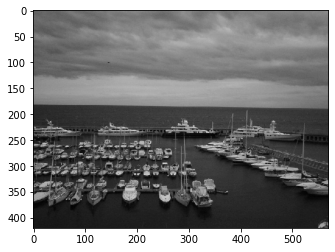

In [5]:
file_dir = 'images/'
file_name = 'boat'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/boat.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)

display_image(img_gray)
img_gray.shape

As you can see, this image has pretty bad contrast : it is difficult to see in it. Now, display the histogram of this image to show this (see the intro to images notebook for help)

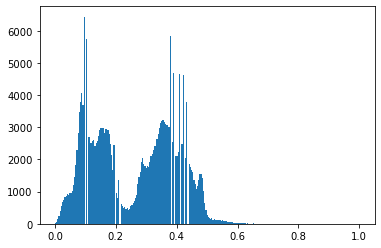

In [6]:
_ = plt.hist(img_gray.flatten(), bins=np.linspace(0,1,256))

You will notice that the histogram is not very well spread out over the whole range of the image. We are going to correct this in this part of the TP, by imposing a __uniform histogram__ on the image.

Firstly, calculate the cumulative histogram $H$ of the image and display it (use the np.cumsum function).

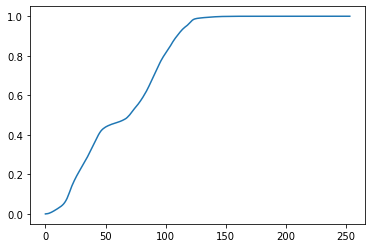

In [7]:
hist_vals,_ = np.histogram(img_gray.flatten(), bins=np.linspace(0,1,255))
plt.plot(np.cumsum(hist_vals)/(img_gray.shape[0]*img_gray.shape[1]))

## Histogram equalisation

Now, if we apply the cumulative histogram $H$ as a contrast change, then we are imposing a uniform histogram on the image (see the lesson slides). A contrast change means we do not change the order of the __values__ of the pixels. We are going to use $H$ as a type of lookup table to find the new values of the image.

In practice, this can be done with the following method :

- normalise the cumulative histogram such that the largest value is 1.0. This will map the final image to the interval $0, \dots, 1$ (you will still have a discrete list of values, but floating point ones)
- convert the image grey-levels back to the interval $\{0, \dots 255\}$ as int values. This will allow us to use these values as indices in H
- apply the cumulative histogram to the values of the image pixels

Implement this algorithm now in a function ``equalize_histogram``. __Note__ In the ``np.histogram`` function, the histogram values have one less element than the histogram bins

In [8]:
def equalize_histogram(img_in):
    shape = img_in.shape

    hist_vals, hist_bins = np.histogram(img_in.flatten(), bins=np.linspace(0,1,257))
    cumul = np.cumsum(hist_vals)
    cumulative_hist = cumul / cumul.max()
    int_img = img_in * 255
    flattened_img = int_img.flatten()
    flattened_img = np.array([cumulative_hist[int(x)] for x in flattened_img])
    img_equalise = flattened_img.reshape((shape[0],shape[1]))
    return img_equalise

Carry out the algorithm on the input image and display the image. Is the result better ?

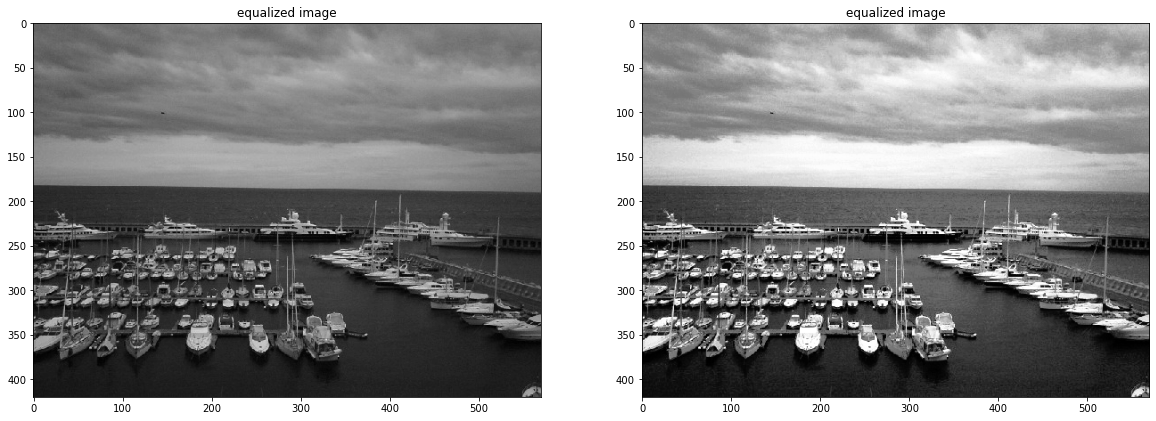

In [21]:
img_gray_equalise = equalize_histogram(img_gray)

fig = plt.figure(figsize=(20,20))

fig.add_subplot(1,2,1)
display_image(img_gray)
plt.title('equalized image')

fig.add_subplot(1,2,2)
display_image(img_gray_equalise)
plt.title('equalized image')
plt.show()

Now, we display both the histogram and cumulative histogram of the equalised image

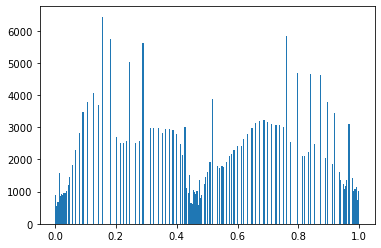

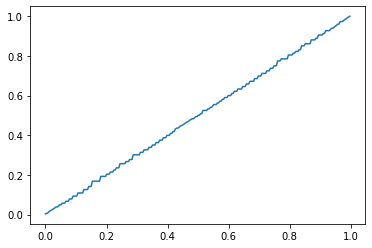

In [12]:
hist_vals, hist_bins,_ = plt.hist(img_gray_equalise.flatten(), bins=np.linspace(0,1,255))
plt.figure()
plt.plot(hist_bins[:-1],hist_vals.cumsum()/hist_vals.cumsum().max())

__Questions__ Is the histogram of the equalised image perfectly uniform (flat) ? Why is this the case ?

__Answer__

### Colour images

Let us try to apply our algorithm to a colour image. First, let's read the image and display it

(761, 1142, 3)

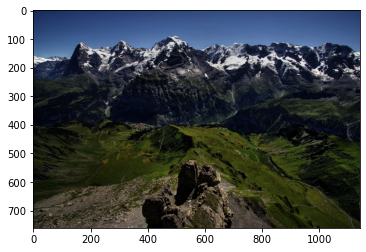

In [13]:
file_dir = 'images/'
file_name = 'alps_contrast'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/alps_contrast.png"
  _,img_color = read_image(file_name+file_ext)
else:
  _,img_color = read_image(file_dir+file_name+file_ext)

display_image(img_color)
img_color.shape

Now, create a function ``equalize_histogram_color`` which uses your grey-level function to carry out colour histogram equalisation in each colour channel independently, and display the output image. Careful to

- normalise the input range to $0, \dots, 1$ for each channel when processing it
- put the output range back to $0, \dots, 255$ when displaying.

To view the result better, you can write it to a file.

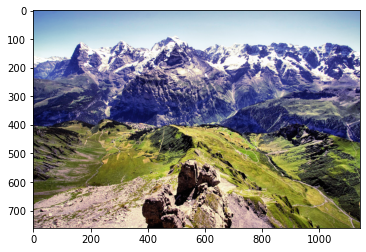

In [14]:
def equalize_histogram_color(img_color):
    shape = img_color.shape
    img_color_normalised = img_color / 255
    r = equalize_histogram(img_color_normalised[:,:,0])
    g = equalize_histogram(img_color_normalised[:,:,1])
    b = equalize_histogram(img_color_normalised[:,:,2])
    img_color_equalized = np.zeros(shape)
    img_color_equalized[:,:,0] = r
    img_color_equalized[:,:,1] = g
    img_color_equalized[:,:,2] = b
    return img_color_equalized


img_color_equalized = equalize_histogram_color(img_color)
display_image(255.0 * img_color_equalized)

write_image(img_color_equalized,file_name+'_equalised.png')

__Question__ Do you think this result looks right ? What may be wrong in our approach ? What could be a solution to this ?

__Answer__

- The montains are blue this is odd !
- What it is wrong is that we have applied our algorithm idependtly on the three dimensions red green and blue that are iterconnected. Thus it yiels on the image a noticeable changes in the image's color balance since the relative distributions of the color channels change when applying the algorithm that we made. 
- We could convert our image in anothor space. For instance on wikipedia they propose that  we first convert in the HSL/HSV color space and then apply the algorithm to the luminance.